## Predicting the Success of Cyber-Related Terrorist Attacks:

This dataset is from Global Terrorism Database curated by the University of Maryland:

National Consortium for the Study of Terrorism and Responses to Terrorism (START). (2018). Global Terrorism Database [Data file]. Retrieved from https://www.start.umd.edu/gtd.

It is a rich dataset with numerous variables and plenty of opportunities for analysis.  In this project, we will focus on predicting the 'success' of attacks which are related to cyber-events or have consequences for cyber-infrastructure (we will describe these characteristics in further detail below.   

To begin, we will take a look at how this study classifies a successful terrorist attack and distinguishes it from an unsuccessful attack.  Below, is their description from pages 11 and 26 of their code-book (__[GTD Global Terrorism Database. Codebook: Inclusion Criteria and Variables](http://www.start.umd.edu/gtd/downloads/Codebook.pdf)__):

> "The GTD does not include plots or conspiracies that are not enacted, or at least attempted. For
an event to be included in the GTD, the attackers must be “out the door,” en route to execute
the attack. Planning, reconnaissance, and acquiring supplies do not meet this threshold.
The GTD does include attacks that were attempted but ultimately unsuccessful. The
circumstances vary depending on tactics (for details see the success variable, below). However,
in general if a bomb is planted but fails to detonate; if an arsonist is intercepted by authorities
before igniting a fire; or, if an assassin attempts and fails to kill his or her intended target, the
attack is considered for inclusion in the GTD, and marked success=0." P. 11

> "Success of a terrorist strike is defined according to the tangible effects of the attack.
Success is not judged in terms of the larger goals of the perpetrators. For example, a
bomb that exploded in a building would be counted as a success even if it did not
succeed in bringing the building down or inducing government repression.
The definition of a successful attack depends on the type of attack. Essentially, the
key question is whether or not the attack type took place. If a case has multiple
attack types, it is successful if any of the attack types are successful, with the
exception of assassinations, which are only successful if the intended target is killed.
        1 = "Yes" The incident was successful.
        0 = "No" The incident was not successful." P. 26

Thus, our focus below will be on using the data collected to build a model which will successfully predict the success of a terror attack.  Below, we will begin importing and working with our data, and explanations and analysis will follow when pertinent.

In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import gc
import sys
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


### 1. Importing, Cleaning and General Overview:

#### A. Importing Data.

In [3]:
df = pd.read_excel('globalterrorismdb_0718dist.xlsx', 
                   usecols = 'A, I, K, M, S:W, AA:AB, AD, AJ, AL, AM, AN, AP, BG, BM:BN, BQ, CE, CG, DA',
                   dtype = {'summary':str, 'motive':str})                                                                                         

In [4]:
# Renaming our columns for usability:

cyber_data = pd.DataFrame(df.rename({'eventid':'event_id', 'doubtterr':'doubt', 'attacktype1_txt':'attack_1txt', 
                                     'targtype1_txt':'target_1txt', 'targsubtype1':'sub_target',
                                     'targsubtype1_txt':'sub_targettxt', 'target1':'specific_target',
                                     'natlty1_txt':'victim_nationalitytxt', 'gname':'group_name', 
                                     'guncertain1':'group_attrib_crtainty', 'individual':'unaffil_individ', 
                                     'weaptype1':'weapon', 'weaptype1_txt':'weapontxt', 
                                     'weapsubtype1':'sub_weapon', 'weapsubtype1_txt':'sub_weapontxt'}, axis = 1))

In [5]:
# Went ahead and dropped some null values here since our kernel started to crash repeatedly:

start_len = cyber_data.shape
cyber_data.dropna(axis = 0, how = 'any', inplace = True)
mid_len_1 = cyber_data.shape


In [6]:
del df
gc.collect()

363439

#### B. Selecting Rows Specific to Cyber-Related Terrorism:

In order to filter the dataset and focus our inquiry on cyber-related events, we will use the following regex statement.  This statement attempts to focus on social-networks, email platforms as well as infrastructure (to a certain extent).

It should be note that this statement is susceptible to bias in a few ways.  First of all, it is temporally biased in the sense that it includes Facebook and Twitter, while newer platforms or platforms in other countries might be prevalent. One way to reduce this bias would be to update the expression whenever possible with current data and considerations of standard practice and user habits.

In [7]:
# Creating the input Dataframe (cyber_train):
# Using regex to isolate qualifying data and make a mask to filter our main dataframe:

import re

  # First taking a look to see how many rows that will give us to work with:
    
print(cyber_data.summary.str.contains('cyb+|social|inform+|network+|twit+|facebook|fake|electio+|internet|ads|adv+|priv+|hac+|breac+|emai+',
                         flags = re.IGNORECASE, regex = True).value_counts())

# Creating the mask:

mask = cyber_data.summary.str.contains(r'(cyb+|social|inform+|network+|twit+|facebook|fake|electio+|internet|ads|adv+|priv+|hac+|breac+|emai+)', 
                           flags = re.IGNORECASE)

# Filtering our main data:

cyber_data = pd.DataFrame(cyber_data[mask])

False    109486
True       7047
Name: summary, dtype: int64


#### C. Splitting Our Train/Test Data:

Below, we dropped some specific columns in dataframe in order to make future processing more efficient.  The 'event_id' column wasn't numerically significant and created problems when getting dummies was necessary. The same occured with 'summary' and 'motive.'  These last two columns, however, will come in handy when considering avenues for further research, which we will discuss below.

In [8]:
from sklearn.model_selection import cross_val_score, train_test_split

# Defining our Input and Output data:
# (Cleaning afterwards to prevent leakage)

X = cyber_data.drop(['event_id', 'success', 'summary', 'motive'], axis = 1)
Y = pd.DataFrame(cyber_data['success'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .25)

X_train_start_index = X_train.index
X_test_start_index = X_test.index

In [9]:
# Memory Mitigation (Resource cited below):

ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

cleaner = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], 
                 key=lambda x: x[1], reverse=True)

In [10]:
del X, mask, Y, cleaner
gc.collect()

7

#### D. Isolating Columns:

We want to be sure we are only using the numeric columns that are significant (i.e. binary or numerically related to the values they contain) and not arbitrary categoricals (such as using numbers to classify one instance over another).  Initially, we imported more of the dataset which included different types of data-types.  After running the notebook as it was closer to its final form, it took considerably longer to load, at which point we dropped most of these columns from our initial read-in of the data. We account for a few lingering columns below:

In [11]:
cyber_train_X = X_train[['country_txt', 'region_txt', 'city', 'crit1', 'crit2', 'crit3', 'doubt',
                       'suicide', 'attack_1txt', 'target_1txt', 'sub_targettxt', 'corp1',
                       'specific_target', 'victim_nationalitytxt', 'group_name',
                       'group_attrib_crtainty', 'unaffil_individ', 'weapontxt',
                       'sub_weapontxt']]

# Making sure input and output dataframes still have the same amount of rows:

cyber_train_Y = Y_train.iloc[Y_train.index == cyber_train_X.index]

In [12]:
# Applying the same process above to our test data:

cyber_test_X = X_test[['country_txt', 'region_txt', 'city', 'crit1', 'crit2', 'crit3', 'doubt',
                       'suicide', 'attack_1txt', 'target_1txt', 'sub_targettxt', 'corp1',
                       'specific_target', 'victim_nationalitytxt', 'group_name',
                       'group_attrib_crtainty', 'unaffil_individ', 'weapontxt',
                       'sub_weapontxt']]

cyber_test_Y = Y_test.iloc[Y_test.index == cyber_test_X.index]

In [13]:
del X_train, X_test, Y_train, Y_test

#### E. Applying Filters to Text Columns.

The cells below are an attempt to consolidate (or group) some of the values together with a few certain columns we will be focusing on.  Given that these columns have a considerable number of unique values, when getting dummies later, it will greatly increase the size of our feature set.  While an increased feature-set is not necessarily a bad thing, preventing the size from becoming too large will aid in our explanatory power later on.  In other words, our feature set will have a comprehensible size, allowing us to explain the characteristics around a successful attack. Otherwise, we run the risk of a feature set which is too large for a human to understand and too many features - making it difficult to see which columns/characteristics are significant for our analysis.

Below, we focus mainly on the types of weapons, the named terrorist groups and the cities attacked.  We also consolidated some of the sub_targets into larger groups.  After running our preliminary models, we found that targets and sub_targets were significant to our models, so we conducted some further feature engineering afterwards, which we will discuss later.

There were a number of resources which were helpful in this grouping process, which we will lay out here:

Regarding the 'weapontxt' column, which describes the type of weapons used in the attack, and the 'sub_target' column (which provides further details on the primary target) we mainly referred to the codebook accompanying the study (as mentioned above: (__[GTD Global Terrorism Database. Codebook: Inclusion Criteria and Variables](http://www.start.umd.edu/gtd/downloads/Codebook.pdf)__)).  The grouping below was rather simple - primarily placing a few types of weapon-groups and sub-targets together when it would not negatively impact our explanatory capabilites down the road.

The 'city' and 'group_name' columns were more technical and involved some outside research.  The groupings below are aimed at linking cities together if they fall within an ideological, religious, environmental or political umbrella in which certain terrorist groups are interested.  For example, some middle-eastern cities are considered to lean more 'Sunni' as opposed to 'Shia', while others are 'split.'  Some South American cities lie within an area experiencing heavy gang activity (such as the Northern Triangle between Mexico and Panama).  Our goal with these groupings was to combine cities whenever they had a common interest factor for terrorist events, in the hopes that it would consolidate their correlation and aid in our predictive models.  

These groupings, however, can be improved upon with further in-depth research.  Our time with this project was somewhat limited and there are a handful of regions we were unable to group together or research.  Additionally, our expertise in global terrorism is slight in comparison to those working in the field, which would benefit from an expert team member when creating these filters.  That said, it would be highly interesting to continue improving these classifications, especially given the wealth of information and databases made available by respected international research organizations, which we will list here:

Some cities and groups were classified according to their religious leanings:

- Some Middle-Eastern cities were grouped under a Sunni/Shia or Sunni/Shia Split category.  These resources were helpful in ascertaining where a city fell with respect to these religious tendencies:
-  A New York Times article by Sarah Almukhtar, Sergio Peçanha and Tim Wallace on January 5th, 2016, entitled: __[Behind Stark Political Divisions, a More
Complex Map of Sunnis and Shiites.](https://www.nytimes.com/interactive/2016/01/04/world/middleeast/sunni-shiite-map-middle-east-iran-saudi-arabia.html)__
- A blog post by Olivier Ypsilantis on August 14th, 2014, entitled: __[Carte religieuse de l’Iran et ses voisins](http://zakhor-online.com/?attachment_id=7932)__.
- Max Fisher wrote a great article for Vox on March 26th, 2015 which has a lot of great maps for reference: __[40 maps that explain the Middle East](https://www.vox.com/a/maps-explain-the-middle-east)__
The Gulf 2000 Project has a plethora of maps and resources regarding issues in the Middle-East, and specifically this page by Dr. Michael Izady entitled __[Atlas of the Islamic World and Vicinity
(Infographs, Maps and Statistics Collection).](http://gulf2000.columbia.edu/maps.shtml)__ Some other maps we used from this site were: - __[A map of West Africa](http://gulf2000.columbia.edu/images/maps/West_Africa_Religion_lg.png)__
 - __[A map of Libya](http://gulf2000.columbia.edu/images/maps/Libya_Religion_Western_Sector_lg.png)__
 - __[A Shia territories map](http://gulf2000.columbia.edu/images/maps/ShiasReligionCore_lg.png)__

The Crisis Group also has a number of useful resources and articles regarding these topics.  Specifically regarding Colombia and South America, we referenced and article entitled __[Colombia’s Armed Groups Battle for the Spoils of Peace](https://www.crisisgroup.org/latin-america-caribbean/andes/colombia/63-colombias-armed-groups-battle-spoils-peace)__ from Report  63 / Latin America & Caribbean 19 OCTOBER 2017.  There was an interesting map by Mike Shand (International Crisis Group 2017), entitled __[Map of Armed Groups and Coca Crops in Colombia, 2017.](https://www.crisisgroup.org/latin-america-caribbean/andes/colombia/63-colombias-armed-groups-battle-spoils-peace#map-5700-8)__.

We'll also take this opportunity to list out further databases and resources we used for this project:

For 'group_names' we referenced START's resources again (as they have a wealth of resources surrounding the database we used and the elements it describes.  Here, they list the names of __['Big, Allied and Dangerous' terrorist groups,](http://www.start.umd.edu/baad/database)___ which we used as the basis for a majority of our classification.

The __[SATP website](http://www.satp.org/conflict-maps/bangladesh)__ was instrumental in gaining insight into Asian conflicts. Within this website, we referenced a specific article regarding the 
__[Nepalise Maoist conflicts](http://www.satp.org/terrorist-profile/nepal/communist-party-of-nepal-maoist)__, which described their objectives, operating areas, leaders, etc.  Towards the bottom of the page, it includes a ranking by the Nepalese Home Ministry, of areas in Nepal according to their sensitivity to these issues.  We then used this __[map](https://reliefweb.int/map/nepal/nepal-regions-zones-and-districts-cities-april-2015)__ from ReliefWeb to help us locate smaller cities in pertinent areas.

South America and the Northern Triangle:

Again, there are a number of databases and materials available from top-level international organizations.  Regarding the Northern Triangle (namely Guatemala, Honduras, El Salvador) we referenced the following articles:
 - __[Central America’s Violent Northern Triangle](https://www.cfr.org/backgrounder/central-americas-violent-northern-triangle)__By Rocio Cara Labrador and Danielle Renwick (updated June 26th, 2018) 
 - The Insight Crime Organiztion has a main page for each country involved in frequent conflicts__[such as this one regarding El Salvador](https://www.insightcrime.org/el-salvador-organized-crime-news/)__   
 - Relief Web also had a variety of resources we used here, specifically a __[main search page](https://reliefweb.int/country/slv)__ for each country that leads to reports, infographics and the like.
 - The __[Humanitarian Reponse Group](https://www.humanitarianresponse.info/en/infographics)__ also has great resources and infographics.
 - The __[United Nations Regional Information Centre](https://www.unric.org/en/databases/26912-refugees-humanitarian-affairs-and-migration)__ points to a number of outside resources depending on what one is looking for.
 - In refrencing hotspots of violence in Guatemala, we used Relief Web's summary on __[Humanitarian Needs Overview for Guatemala in 2017](https://reliefweb.int/sites/reliefweb.int/files/resources/20180315_SUMMARY_HNO%20GT_ENG.pdf)__
 - Regarding the same of El Salvador, we used Relief Web's __[Map of El Salvador.](https://reliefweb.int/sites/reliefweb.int/files/resources/20180405%20monthly%20humanitarian%20snapshot%20-%20ENG.pdf)__
 - For Honduras we referred to an article entitled __['Northern Triangle is World's Extortion Hotspot'](https://www.insightcrime.org/news/brief/northern-triangle-world-extortion-hotspot/)__ by Steven Dudley and Michael Lohmuller on JULY 1st, 2015.  This article has a map that was helpful in locating our cities.
 - Regarding Columbia, we frequently referred to the __[Crisis Group's resources.](https://www.crisisgroup.org/)__ 
There were two articles in particular we referred to here.  The first was entitled 'Colombia’s Armed Groups Battle for the Spoils of Peace' (which we already referenced above).  The second was a map entitled __['Map of ELN Presence in Colombia in 2012 and 2018, and Expansion between 2012 and 2018'](https://www.crisisgroup.org/latin-america-caribbean/andes/colombia/68-missing-peace-colombias-new-government-and-last-guerrillas#map-6189-1)__ within an article named __['The Missing Peace: Colombia’s New Government and Last Guerrillas'](https://www.crisisgroup.org/latin-america-caribbean/andes/colombia/68-missing-peace-colombias-new-government-and-last-guerrillas)__ from their Report 68 / Latin America & Caribbean on July 12th, 2018.

Other General References include:

 - __[Homeland Security Digital Library](https://www.hsdl.org/?collection&id=2167)__
 - __[U Mass Lowell](https://www.uml.edu/Research/CTSS/Online-Resources.aspx)__ Has a great page with links to further resources.
 - The Council on Foreign Relations has a page entitled __[Invisible Armies Insurgency Tracker: A Visual History of Guerrilla Warfare From 1775 to 2012 (from April 18th, 2013](https://www.cfr.org/wars-and-warfare/invisible-armies-insurgency-tracker/p29917)__.  As they describe it at the top of the page: "The interactive Invisible Armies Insurgency Tracker presents a database of insurgencies from 1775 to 2012. It supplements the comprehensive historical narrative in Invisible Armies: An Epic History of Guerrilla Warfare from Ancient Times to the Present, by CFR Senior Fellow Max Boot."
 - West Point has __[The Combating Terrorism Center](https://ctc.usma.edu/regions/middle-east/)__ which is incredibly helpful and insightful with their background information.
 - __[The Terrorism Research and Analysis Consortium](https://www.trackingterrorism.org/region/afghanistan)__ has a lot of information - mostly private and paid, but one can at least browse the surface of what they offer (we also used some of their 'vulnerable cities' classifications in our cells below).

##### 1. Defining Categories for Values within 'Sub_targettxt', 'Group_Name' and 'City':

In [14]:
# Here is the function we will use to take our list of values and replace it with specific group/category names:
    # We will do this for each of the test and training sets:
    
def magic_value_replacer(df, column, variable, string):
    
    df[column] = df[column].replace(variable, string)
    

###### Sub_targettxt:

In [15]:
industrial = ['Gas/Oil/Electric', 'Industrial/Textiles/Factory', 'Farm/Ranch', 'Mining', 'Construction']

white_collar = ['Restaurant/Bar/Café', 'Bank/Commerce', 'Multinational Corporation', 
                'Medical/Pharmaceutical', 'Retail/Grocery/Bakery (including cell phone shops and generic shops)', 
                'Hotel/Resort', 'Entertainment/Cultural/Stadium/Casino', 'Private Security Company/Firm',
                'Legal Services', 'Retail/Grocery/Bakery']

gov_figure1 = ['Judges/Attorneys/Courts', 'Judge/Attorney/Court', 
               'Government Personnel (excluding police, military)']

gov_figure2 = ['Politician or Political Party Movement/Meeting/Rally', 'Royalty', 'Head of State',
               'Election Related', 'Election-related']

pol_facilities = ['Police Buildings (Headquarters/Stations/School)', 
                  'Police Patrol (including vehicles and convoys)', 'Police Checkpoint', 'Prison/Jail', 
                  'Police Building (headquarters, station, school)']

mil_facilities = ['Military Barracks/Base/Headquarters/Checkpost', 'Military Recruiting Station/Academy',
                       'Military Weaponry', 'Military Aircraft', 'Military Maritime', 'Paramilitary', 
                       'Military Transportation/Vehicle (excluding convoys)', 'Military Checkpoint']

mil_personnel = ['Military Unit/Patrol/Convoy', 'Non-combatant Personnel', 
                      'Military Personnel (soldiers, troops, officers, forces)']

gov_diplomatic = ['Diplomatic Personnel (outside of embassy, consulate)', 'Embassy/Consulate', 'NATO', 
                  'International Organization (peacekeeper, aid agency, compound)']

educational = ['Teacher/Professor/Instructor', 'School/University/Educational Building', 'Other Personnel']

food_water = ['Food Supply', 'Water Supply']

internet_comm_information = ['Newspaper Journalist/Staff/Facility', 'Radio Journalist/Staff/Facility', 
                             'Television Journalist/Staff/Facility', 'Other (including online news agencies)',
                             'Radio', 'Internet Infrastructure', 'Television', 'Electricity', 
                             'Telephone/Telegraph']

religious = ['Religion Identified', 'Religious Figure', 'Place of Worship', 'Affiliated Institution']

political = ['Protrainer', 'Political Party Member/Rally', 'Party Official/Candidate/Other Personnel', 
             'Party Office/Facility', 'Rally']

mass_socio = ['Refugee (including Camps/IDP/Asylum Seekers)', 'Named Civilian', 'Student', 
              'Race/Ethnicity Identified', 'Farmer', 'Vehicles/Transportation', 'Marketplace/Plaza/Square', 
              'Village/City/Town/Suburb', 'House/Apartment/Residence', 'Laborer (General)/Occupation Identified', 
              'Procession/Gathering (funeral, wedding, birthday, religious)', 'Civilian Maritime',
              'Public Areas (e.g., Public garden, parking lot, garage, beach, public buildings, camps)',
              'Public Area (garden, parking lot, garage, beach, public building, camp)', 'Port', 
              'Memorial/Cemetery/Monument', 'Museum/Cultural Center/Cultural House', 'Labor Union Related', 
              'Tourism Travel Agency', 'Tour Bus/Van/Vehicle', 'Tourist', 'Other Facility', 'Airport',
              'train/train Tracks/ Trolley', 'Bus Station/Stop', 'Subway', 'Bridge/Car Tunnel', 
              'Highway/Road/Toll/Traffic Signal', 'Taxi/Rickshaw', 'Bus (excluding tourists)', 
              'Commercial Maritime', 'Train/Train Tracks/Trolley', 'Aircraft (not at an airport)', 
              'Airline Officer/Personnel', 'Aircraft (not at an airport)', 
              'Demilitarized Zone (including Green Zone)']

first_responders = ['Clinics', 'Fire Fighter/Truck', 'Ambulance']

other_utilities = [ 'Gas', 'Oil', 'Oil Tanker']

###### specific_target:

There were some duplicates here that were related to what we are looking for, so I went ahead and combined them in the hopes that they might lead to some more insights.

In [16]:
cell_tower = ['Cell tower', 'Cell phone tower',  'Cell Tower', 'Cell Phone Tower']
polling_areas = ['Polling Station', 'Polling Center', 'Polling Stations', 'Polling Booth']

###### Group_name: (Grouping by Ideology, Political Tendencies, Etc.)

In [17]:
palestinian_separatists = ['Hamas (Islamic Resistance Movement)', 'Palestinian Islamic Jihad (PIJ)',
                           'Popular Front for the Liberation of Palestine (PFLP)', 'Popular Resistance Committees',
                           'Al-Fatah']

militants = ['Militants', 'Gunmen']

asian_separatists = ['Abu Sayyaf Group (ASG)', 'Colonel Karuna Faction', 'Eastern Turkistan Islamic Movement (ETIM)',
                     'Free Aceh Movement (GAM)', 'Janatantrik Terai Mukti Morcha (Jtmm)', 
                     'Janatantrik Terai Mukti Morcha- Goit (Jtmm-G)', 
                     'Janatantrik Terai Mukti Morcha- Jwala Singh (Jtmm-J)',
                     'Janatantrik Terai Mukti Morcha- Rajan Mukti (Jtmm-R)',
                     'Liberation Tigers of Tamil Eelam (LTTE)', 'Moro Islamic Liberation Front (MILF)',
                     'Runda Kumpulan Kecil (Rkk)', 'Terai Army']

middle_eastern_separatists = ['Haqqani Network', 'Harkatul Jihad-E-Islami', 'Lashkar-E-Taiba (Let)',
                             'Kurdistan Workers\' Party (PKK)', 'Lashkar-E-Balochistan', 'Chechen Rebels',
                             'Free Syrian Army', 'Caucasus Emirate', 'Baloch Republican Army (BRA)',
                             'Ansar Al-Islam', 'Kurdistan Free Life Party', 'Baloch Liberation Front (Blf)',
                             'Baloch Liberation Army (BLA)', 'Ansar Al-Sharia (Libya)', 'Jaish-E-Mohammad (Jem)',
                             'Riyadus-Salikhin Reconnaissance And Sabotage Battalion Of Chechen Martyrs',
                             'Hizbul Mujahideen (Hm)', 'Southern Mobility Movement (Yemen)',
                             'Supreme Council For Islamic Revolution In Iraq (Sciri)']

indian_separatists = ['Dima Halao Daoga (Dhd)', 'Black Widows', 'Garo National Liberation Army',
                      'Kangleipak Communist Party (KCP)', 'National Democratic Front of Bodoland (NDFB)',
                      'National Liberation Front of Tripura (NLFT)', 'People\'s Liberation Army (PLA)',
                      'United Liberation Front of Assam (ULFA)', 'United National Liberation Front (UNLF)',
                      'Karbi Longri North Cachar Liberation Front (Klnlf)', 
                      'National Socialist Council of Nagaland-Isak-Muivah (NSCN-IM)',
                      'People\'s Revolutionary Party of Kangleipak (PREPAK)']

NW_indian_groups = ['Lashkar-e-Jhangvi', 'Sipah-e-Sahaba/Pakistan (SSP)', 'Hizbul Mujahideen (HM)', 
                    'Baloch Liberation Front (BLF)', 'Baloch Young Tigers (BYT)', 'Baloch Young Tigers (BYT)',
                    'Baloch Liberation Army (BLA)', 'Baloch Republican Army (BRA)', 'United Baloch Army (UBA)',
                    'Free Balochistan Army (FBA)', 'Baloch Nationalists']

SE_indian_groups = ['Communist Party of India - Maoist (CPI-Maoist)', 'Indian Mujahideen', 
                    'Jama\'atul Mujahideen Bangladesh (JMB)', 'Bangladesh Sarbahara Party',
                    'Purbo Banglar Communist Party', 'Harkatul Jihad-e-Islami',
                    'National Socialist Council of Nagaland-Unification (NSCN-U)',
                    'Kanglei Yawol Kanna Lup (KYKL)', 'Kuki Tribal Militants', 'Kuki National Front (KNF)',
                    'United Kuki Liberation Front (UKLF) - India', 'Hill Tiger Force (HTF)',
                    'National Socialist Council of Nagaland-Khaplang (NSCN-K)',
                    'National Socialist Council of Nagaland-Isak-Muivah (NSCN-IM)',
                    'Hynniewtrep National Liberation Council (HNLC)']

african_political = ['National Union for the Total Independence of Angola (UNITA)']

irish_separatists = ['Real Irish Republican Army (RIRA)', 'Oglaigh Na Heireann', 'Irish Republican Army (IRA)']

FARC_left_right = ['National Liberation Army of Colombia (ELN)', 'Popular Liberation Army (EPL)',
                   'Revolutionary Armed Forces of Colombia (FARC)', 'United Self Defense Units of Colombia (AUC)']

middle_eastern_religious = ['Al-Gama\'at Al-Islamiyya (IG)', 'Al-Nusrah Front', 'Al-Qa\'ida',
                            'Al-Qa\'ida in the Arabian Peninsula (AQAP)', 'Al-Shabaab', 'Ansar Al-Islam',
                            'Ansar Al-Sharia (Libya)', 'Al-Qa\'ida in the Lands of the Islamic Maghreb (AQLIM)',
                            'Asa\'Ib Ahl Al-Haqq', 'Caucasus Emirate', 'Eritrean Islamic Jihad Movement (EIJM)',
                            'Great Eastern Islamic Raiders Front (Ibda-C)', 'Hizbul Al Islam (Somalia)',
                            'Islamic Courts Union (ICU)', 'Islamic State of Iraq and al Sham (ISIS)',
                            'Islamic Movement of Uzbekistan (IMU)', 'Jamiat Ul-Mujahedin (Jum)',
                            'Jundallah', 'Mahdi Army', 'Taliban', 'Tehrik-i-Taliban Pakistan (TTP)', 
                            'Muslim extremists', 'Armed Islamic Group (GIA)', 'Sunni Muslim extremists',
                            'Al-Qaida in the Islamic Maghreb (AQIM)', 'Al-Qaida', 'Al-Qaida in Iraq', 
                            'Islamic State of Iraq and the Levant (ISIL)',
                            'Al-Qaida in the Arabian Peninsula (AQAP)']

israel_palestine_lebanon = ['Anti-Semitic extremists', 'Hezbollah']

asian_african_religious = ['Students Islamic Movement of India (Simi)', 'Ranbir Sena', 'Jemaah Islamiya (JI)', 
             'Movement for Oneness and Jihad in West Africa (MUJAO)', 'Lord\'s Resistance Army (LRA)',
             'Boko Haram']


###### City: (Grouping by Predominate Religion, Political Party or Conflict Issue)

In [18]:
sunni_cities = ['Mosul', 'Kirkuk', 'Sanandaj', 'Ramadi', 'Trabzone', 'Diarbekir', 
                'Damascus', 'Gwadar', 'Zahedan', 'Kandahar', 'Khiva', 'Fallujah',
                'Dakhla', 'Tajura', 'Sabrata', 'Azizia', 'Kasabat', 'Misrata', 'Tripoli',
                'Takrit', 'Tikrit']

shia_cities = ['Mecca', 'Najaf', 'Karbala', 'Samarra', 'Ahwaz', 'Basra', 
               'Medina', 'Tabriz', 'Tunceli', 'Zahran', 'Tehran', 'Rasht', 'Bojnurd',
               'Hillah', 'Diwania', 'Khalis', 'Dujali', 'Balad', 'Khanaqin', 
               'Sargodha', 'Dadu', 'Moro']

split_cities = ['Kirmanshah', 'Baghdad', 'Kadhimia', 'Kuwait', 'Kars', 'Maras', 
               'Ankara', 'Sivas', 'Aleppo', 'Beirut', 'Abha', 'Jizan', 'Qazvin',
               'Gunbad', 'Ashgabat', 'Mashhad', 'Herat', 'Merv', 'Charju', 'Bukhara',
               'Samarkand', 'Mazari Sharif', 'Kandahar', 'Lar', 'Bandar Abbas', 'Dubai', 
               'Abu Dhabi', 'Tashkent', 'Erzurum', 'Konya', 'Izmir', 'Bursa', 'Istanbul',
               'Tarhuna', ]

ibadi_cities_libya = ['Nalut', 'Zentan', 'Gharian', 'Dafnia', 'Abu Kammash', 'Zuwara']

columbia_eln_cities = ['Riosucio', 'Buenaventura', 'Cali', 'Popayán', 'Bucaramanga',
                       'Barrancabermeja', 'Cucuta', 'Santa Rita']

maoist_insurgency = ['Bhagalpur', 'Arwal', 'Khagaria', 'Rohtas', 'Kaimur',
                       'Bhabua', 'Munger', 'Monghyr', 'Vaishali',
                    'Dhanbad', 'Pakur', 'Koderma', 'Palamu', 'Balaghat',
                     'Katni', 'Khandwa', 'Rajgarh', 'Shajapur']

w_africa_muslim = ['Touba', 'N\'Djamena', 'Maiduguri', 'Zaria', 'Sokoto', 'Kenema',
                   'Cetoua', 'Mopte', 'Bobo-Dioulasso', 'Kayes', 'Monrovia']

w_africa_mixed = ['Dogondutchi', 'Niamey', 'Parakou', 'Abuja', 'Kaduna', 'Kankan',
                  'Lagos', 'Port Harcourt', 'Couala', 'Yaounde', 'Kumasi', 'Bamako',
                  'Bertoua', 'Liberville', 'Port-Gentil', 'Zinder', 'Ouagadougou',
                  'Freetown', 'Conakry', 'Bissau', 'Banjul', 'Dakar']

w_africa_christian = ['Benin City', 'Onitsha', 'Abidjan', 'Takoradi', 'Accra', 'Lome']


# Nepal Maoist Conflict - Class A According to SATP
Nepal_maoist_A = ['Musikot', 'Rukumkot', 'Jajarkot District', 'Salyan', 'Pyuthan', 'Gajul', 'Rank', 'Budagaun',
                  'Kalikot District', 'Rolpa', 'Rolpa District', 'Rukum District', 'Khalanga']

# Nepal Maoist Conflict - Class B According to SATP
Nepal_maoist_B = ['Charikot', 'Dolakha', 'Jiri', 'Ramechhap', 'Sindhuli Garhi', 'Sindhuli District', 'Dhungrebas',
                  'Panaoti', 'Gorkha', 'Tulsipur', 'Ghorahi', 'Surkhet', 'Birendranagar',
                  'Accham', 'Kamal Bajar', 'Dang', 'Dang District']

# Nepal Maoist Conflict - Class C According to SATP
Nepal_maoist_C = ['Khotang Bajar', 'Khotang District', 'Khandanda', 'Okhaldhunga', 'Rumjatar', 'Udayapur Garhi',
                  'Rasuwa District', 'Gaighat', 'Hitura', 'Makwanpur Garhi', 'Patan', 'Baglung', 'Dhorpatan',
                  'Bardiya', 'Gulariya', 'Dailekh', 'Dailekh District', 'Jumla', 'Dhading District', 
                  'Udayapur District', 'Lalitpur', 'Hetauda', 'Gulariya']


# N_Triangle_S.America:
northern_triangle = ['Tegucigalpa', 'San Pedro Sula', 'Guatemala City', 'Villa Nueva', 'Villa Canales', 
                     'Mixco', 'San Jan Sacatepequez', 'Chinautla', 'Escuintla', 'Jalapa', 'Puerto Barrios', 
                     'Morales', 'La Libertad', 'Nueva Concepcion', 'Metapan', 'Acajutla', 'Sonsonate',
                     'Izalco', 'San Salvador', 'Apopa', 'Zaragoza', 'Colon', 'Santa Tecla', 'Usulutan',
                     'San Miguel', 'La Union']


##### 2. Implementing the Filtering Function:

###### Sub_targettxt:

In [19]:
magic_value_replacer(cyber_train_X, 'sub_targettxt', industrial, 'Industrial')
magic_value_replacer(cyber_train_X, 'sub_targettxt', white_collar, 'White_collar')
magic_value_replacer(cyber_train_X, 'sub_targettxt', gov_figure1, 'Gov_Figure1')
magic_value_replacer(cyber_train_X, 'sub_targettxt', gov_figure2, 'Gov_Figure2')
magic_value_replacer(cyber_train_X, 'sub_targettxt', pol_facilities, 'Police_Facilities')
magic_value_replacer(cyber_train_X, 'sub_targettxt', mil_facilities, 'Military_Facilities')
magic_value_replacer(cyber_train_X, 'sub_targettxt', mil_personnel, 'Military_Personnel')
magic_value_replacer(cyber_train_X, 'sub_targettxt', gov_diplomatic, 'Gov_Diplomatic')
magic_value_replacer(cyber_train_X, 'sub_targettxt', educational, 'Educational')
magic_value_replacer(cyber_train_X, 'sub_targettxt', food_water, 'Food_Water')
# magic_value_replacer(cyber_train_X, 'sub_targettxt', internet_comm_information, 'Info/Comm/Internet')
magic_value_replacer(cyber_train_X, 'sub_targettxt', religious, 'Religious')
magic_value_replacer(cyber_train_X, 'sub_targettxt', political, 'Political')
magic_value_replacer(cyber_train_X, 'sub_targettxt', mass_socio, 'Mass_Socio')
magic_value_replacer(cyber_train_X, 'sub_targettxt', first_responders, 'First_Responders')
magic_value_replacer(cyber_train_X, 'sub_targettxt', other_utilities, 'Other_Utilities')

In [20]:
magic_value_replacer(cyber_test_X, 'sub_targettxt', industrial, 'Industrial')
magic_value_replacer(cyber_test_X, 'sub_targettxt', white_collar, 'White_collar')
magic_value_replacer(cyber_test_X, 'sub_targettxt', gov_figure1, 'Gov_Figure1')
magic_value_replacer(cyber_test_X, 'sub_targettxt', gov_figure2, 'Gov_Figure2')
magic_value_replacer(cyber_test_X, 'sub_targettxt', pol_facilities, 'Police_Facilities')
magic_value_replacer(cyber_test_X, 'sub_targettxt', mil_facilities, 'Military_Facilities')
magic_value_replacer(cyber_test_X, 'sub_targettxt', mil_personnel, 'Military_Personnel')
magic_value_replacer(cyber_test_X, 'sub_targettxt', gov_diplomatic, 'Gov_Diplomatic')
magic_value_replacer(cyber_test_X, 'sub_targettxt', educational, 'Educational')
magic_value_replacer(cyber_test_X, 'sub_targettxt', food_water, 'Food_Water')
# magic_value_replacer(cyber_test_X, 'sub_targettxt', internet_comm_information, 'Info/Comm/Internet')
magic_value_replacer(cyber_test_X, 'sub_targettxt', religious, 'Religious')
magic_value_replacer(cyber_test_X, 'sub_targettxt', political, 'Political')
magic_value_replacer(cyber_test_X, 'sub_targettxt', mass_socio, 'Mass_Socio')
magic_value_replacer(cyber_test_X, 'sub_targettxt', first_responders, 'First_Responders')
magic_value_replacer(cyber_test_X, 'sub_targettxt', other_utilities, 'Other_Utilities')

###### Specific_target: 

In [21]:
magic_value_replacer(cyber_train_X, 'specific_target', cell_tower, 'Cell_tower')
magic_value_replacer(cyber_train_X, 'specific_target', polling_areas, 'Polling_Areas')

magic_value_replacer(cyber_test_X, 'specific_target', cell_tower, 'Cell_tower')
magic_value_replacer(cyber_test_X, 'specific_target', polling_areas, 'Polling_Areas')

###### Group_name: (Grouping by Ideology, Political Tendencies, Etc.)

In [22]:
magic_value_replacer(cyber_train_X, 'group_name', palestinian_separatists, 'Palestinian_Separatists')
magic_value_replacer(cyber_train_X, 'group_name', militants, 'Militants')
magic_value_replacer(cyber_train_X, 'group_name', asian_separatists, 'Asian_Separatists')
magic_value_replacer(cyber_train_X, 'group_name', middle_eastern_separatists, 'Middle_Eastern_Separatists')
magic_value_replacer(cyber_train_X, 'group_name', indian_separatists, 'Indian_Separatists')
magic_value_replacer(cyber_train_X, 'group_name', NW_indian_groups, 'NW_Indian_Groups')
magic_value_replacer(cyber_train_X, 'group_name', SE_indian_groups, 'NW_Indian_Groups')
magic_value_replacer(cyber_train_X, 'group_name', african_political, 'African_Political')
magic_value_replacer(cyber_train_X, 'group_name', irish_separatists, 'Irish_Separatists')
magic_value_replacer(cyber_train_X, 'group_name', FARC_left_right, 'FARC_left_right')
magic_value_replacer(cyber_train_X, 'group_name', middle_eastern_religious, 'Middle_Eastern_Religious')
magic_value_replacer(cyber_train_X, 'group_name', israel_palestine_lebanon, 'Israel_Palestinian_Lebanon')
magic_value_replacer(cyber_train_X, 'group_name', asian_african_religious, 'Asian_African_Religious')

In [23]:
magic_value_replacer(cyber_test_X, 'group_name', palestinian_separatists, 'Palestinian_Separatists')
magic_value_replacer(cyber_test_X, 'group_name', militants, 'Militants')
magic_value_replacer(cyber_test_X, 'group_name', asian_separatists, 'Asian_Separatists')
magic_value_replacer(cyber_test_X, 'group_name', middle_eastern_separatists, 'Middle_Eastern_Separatists')
magic_value_replacer(cyber_test_X, 'group_name', indian_separatists, 'Indian_Separatists')
magic_value_replacer(cyber_test_X, 'group_name', NW_indian_groups, 'NW_Indian_Groups')
magic_value_replacer(cyber_test_X, 'group_name', SE_indian_groups, 'NW_Indian_Groups')
magic_value_replacer(cyber_test_X, 'group_name', african_political, 'African_Political')
magic_value_replacer(cyber_test_X, 'group_name', irish_separatists, 'Irish_Separatists')
magic_value_replacer(cyber_test_X, 'group_name', FARC_left_right, 'FARC_left_right')
magic_value_replacer(cyber_test_X, 'group_name', middle_eastern_religious, 'Middle_Eastern_Religious')
magic_value_replacer(cyber_test_X, 'group_name', israel_palestine_lebanon, 'Israel_Palestinian_Lebanon')
magic_value_replacer(cyber_test_X, 'group_name', asian_african_religious, 'Asian_African_Religious')

###### City: (Grouping by Predominate Religion, Political Party or Conflict Issue)

In [24]:
magic_value_replacer(cyber_train_X, 'city', sunni_cities, 'Sunni_Cities')
magic_value_replacer(cyber_train_X, 'city', shia_cities, 'Shia_Cities')
magic_value_replacer(cyber_train_X, 'city', split_cities, 'Split_Cities')
magic_value_replacer(cyber_train_X, 'city', ibadi_cities_libya, 'Ibadi_Cities_Libya')
magic_value_replacer(cyber_train_X, 'city', columbia_eln_cities, 'Columbia_ELN_Cities')
magic_value_replacer(cyber_train_X, 'city', maoist_insurgency, 'Maoist_Insurgency')
magic_value_replacer(cyber_train_X, 'city', w_africa_muslim, 'W_Africa_muslim')
magic_value_replacer(cyber_train_X, 'city', w_africa_mixed, 'W_Africa_mixed')
magic_value_replacer(cyber_train_X, 'city', w_africa_christian, 'W_Africa_christian')
magic_value_replacer(cyber_train_X, 'city', Nepal_maoist_A, 'Nepal_Maoist_A')
magic_value_replacer(cyber_train_X, 'city', Nepal_maoist_B, 'Nepal_Maoist_B')
magic_value_replacer(cyber_train_X, 'city', Nepal_maoist_C, 'Nepal_Maoist_C')
magic_value_replacer(cyber_train_X, 'city', northern_triangle, 'Northern_Triangle')

In [25]:
magic_value_replacer(cyber_test_X, 'city', sunni_cities, 'Sunni_Cities')
magic_value_replacer(cyber_test_X, 'city', shia_cities, 'Shia_Cities')
magic_value_replacer(cyber_test_X, 'city', split_cities, 'Split_Cities')
magic_value_replacer(cyber_test_X, 'city', ibadi_cities_libya, 'Ibadi_Cities_Libya')
magic_value_replacer(cyber_test_X, 'city', columbia_eln_cities, 'Columbia_ELN_Cities')
magic_value_replacer(cyber_test_X, 'city', maoist_insurgency, 'Maoist_Insurgency')
magic_value_replacer(cyber_test_X, 'city', w_africa_muslim, 'W_Africa_muslim')
magic_value_replacer(cyber_test_X, 'city', w_africa_mixed, 'W_Africa_mixed')
magic_value_replacer(cyber_test_X, 'city', w_africa_christian, 'W_Africa_christian')
magic_value_replacer(cyber_test_X, 'city', Nepal_maoist_A, 'Nepal_Maoist_A')
magic_value_replacer(cyber_test_X, 'city', Nepal_maoist_B, 'Nepal_Maoist_B')
magic_value_replacer(cyber_test_X, 'city', Nepal_maoist_C, 'Nepal_Maoist_C')
magic_value_replacer(cyber_test_X, 'city', northern_triangle, 'Northern_Triangle')

In [26]:
# Mitigating some memory issues:

del industrial, white_collar, gov_figure1, gov_figure2, pol_facilities, mil_facilities, mil_personnel
del gov_diplomatic, educational, food_water, internet_comm_information, religious, political, mass_socio, 
del sunni_cities, shia_cities, split_cities, ibadi_cities_libya, columbia_eln_cities, maoist_insurgency
del w_africa_muslim, w_africa_mixed, w_africa_christian, Nepal_maoist_A, Nepal_maoist_B, Nepal_maoist_C
del northern_triangle, african_political, asian_separatists, middle_eastern_separatists, first_responders
del FARC_left_right, middle_eastern_religious, israel_palestine_lebanon, asian_african_religious, militants
del indian_separatists, NW_indian_groups, SE_indian_groups, irish_separatists, palestinian_separatists, 
del other_utilities, cell_tower, polling_areas

gc.collect()

0

In [27]:
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

cleaner = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], 
                 key=lambda x: x[1], reverse=True)
cleaner

[('cyber_data', 10429396),
 ('cyber_train_X', 4918774),
 ('cyber_test_X', 1640392),
 ('cyber_train_Y', 84584),
 ('X_train_start_index', 42304),
 ('cyber_test_Y', 28216),
 ('X_test_start_index', 14120),
 ('cross_val_score', 136),
 ('magic_value_replacer', 136),
 ('train_test_split', 136),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('skl', 80),
 ('sns', 80),
 ('mid_len_1', 64),
 ('start_len', 64)]

### 2. Preliminary Visualizations and Exploration:

Here we take a look at some of the correlations and relationships between our features/columns and see what we might want to focus on with our models.

In [28]:
pd.set_option('max_columns', 25)
cyber_train_X.describe(include = 'all')

,country_txt,region_txt,city,crit1,crit2,crit3,doubt,suicide,attack_1txt,target_1txt,sub_targettxt,corp1,specific_target,victim_nationalitytxt,group_name,group_attrib_crtainty,unaffil_individ,weapontxt,sub_weapontxt
count,5285,5285,5285,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285,5285,5285,5285,5285,5285,5285,5285.000000,5285.000000,5285,5285
unique,109,12,2534,NaN,NaN,NaN,NaN,NaN,9,21,34,1865,3234,125,282,NaN,NaN,5,29
top,Iraq,South Asia,Split_Cities,NaN,NaN,NaN,NaN,NaN,Bombing/Explosion,Private Citizens & Property,Mass_Socio,Not Applicable,Civilians,Iraq,Unknown,NaN,NaN,Explosives,Unknown Explosive Type
freq,1301,2100,359,NaN,NaN,NaN,NaN,NaN,3073,1426,772,823,292,1248,2973,NaN,NaN,3378,1804
mean,NaN,NaN,NaN,0.989593,0.993377,0.885525,0.162157,0.029328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.099905,0.004730,NaN,NaN
std,NaN,NaN,NaN,0.101491,0.081117,0.318417,0.368630,0.168741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.299902,0.068621,NaN,NaN
min,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,1.000000,1.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,1.000000,1.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,1.000000,1.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN


In [29]:
cyber_train_Y['success'].value_counts()

1    4830
0     455
Name: success, dtype: int64

In [30]:
pd.set_option('max_rows', 110)
cyber_test_X['sub_targettxt'].value_counts()

Mass_Socio                                245
Military_Personnel                        193
Gov_Figure2                               168
Police_Facilities                         154
Unnamed Civilian/Unspecified              147
Gov_Figure1                               147
Police Security Forces/Officers           144
Political                                 105
Military_Facilities                        72
Educational                                52
White_collar                               49
Alleged Informant                          46
Gov_Diplomatic                             39
Industrial                                 37
Government Building/Facility/Office        33
Religious                                  32
Non-State Militia                          25
Newspaper Journalist/Staff/Facility        13
Intelligence                               13
Television Journalist/Staff/Facility        8
International NGO                           7
Terrorist                         

In [31]:
pd.set_option('max_columns', 25)
cyber_data.loc[cyber_data['success'] == 0].describe(include = 'all')

,event_id,country_txt,region_txt,city,summary,crit1,crit2,crit3,doubt,success,suicide,attack_1txt,target_1txt,sub_targettxt,corp1,specific_target,victim_nationalitytxt,group_name,motive,group_attrib_crtainty,unaffil_individ,weapontxt,sub_weapontxt,property
count,6.080000e+02,608,608,608,608,608.000000,608.000000,608.000000,608.000000,608.0,608.000000,608,608,608,608,608,608,608,608,608.000000,608.000000,608,608,608.000000
unique,NaN,48,10,386,603,NaN,NaN,NaN,NaN,NaN,NaN,8,16,69,374,522,51,79,138,NaN,NaN,4,23,NaN
top,NaN,Iraq,South Asia,Baghdad,05/06/2013: Assailants opened fire on the priv...,NaN,NaN,NaN,NaN,NaN,NaN,Assassination,Government (General),"Government Personnel (excluding police, military)",Not Applicable,Polling Station,Iraq,Unknown,nan,NaN,NaN,Explosives,Unknown Explosive Type,NaN
freq,NaN,140,245,29,3,NaN,NaN,NaN,NaN,NaN,NaN,305,232,115,48,9,137,425,290,NaN,NaN,466,172,NaN
mean,2.010801e+11,NaN,NaN,NaN,NaN,0.995066,0.991776,0.955592,0.077303,0.0,0.044408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.088816,0.006579,NaN,NaN,-0.621711
std,6.102456e+08,NaN,NaN,NaN,NaN,0.070128,0.090385,0.206169,0.267291,0.0,0.206169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.284712,0.080910,NaN,NaN,2.911940
min,1.970042e+11,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,-9.000000
25%,2.010061e+11,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000
50%,2.013012e+11,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000
75%,2.014012e+11,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,1.000000


In [32]:
pd.set_option('max_rows', 300)
cyber_train_X['specific_target'].value_counts()

Civilians                                                                                                                 292
Patrol                                                                                                                    269
Vehicle                                                                                                                   221
Soldiers                                                                                                                  112
Officers                                                                                                                   89
Convoy                                                                                                                     86
House                                                                                                                      54
Unknown                                                                                                               

#### B. Correlation:

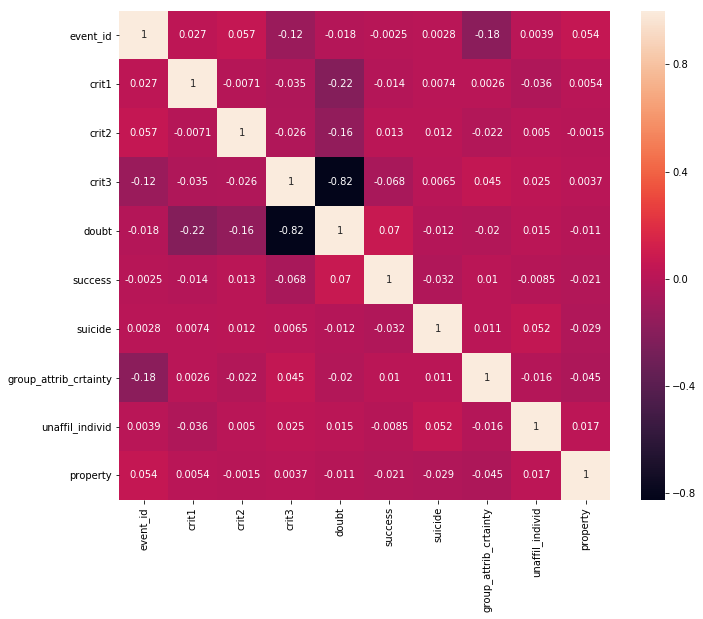

In [33]:
f, ax = plt.subplots(figsize = (11, 9))
sns.heatmap(cyber_data.corr(), annot = True)
plt.show()

#### C. Most Active Groups:

In [34]:
# Most prolific groups:

actives = cyber_train_X['group_name'].value_counts().head(10).drop('Unknown')
mask3 = cyber_train_X['group_name'].map(lambda x: x in actives)
actives_df = cyber_train_X[mask3]

temp_output = cyber_train_Y.loc[actives_df.index]

beta_1 = actives.keys()
gamma_1 = actives.values

# Most affected countries:

hot_countries = cyber_train_X['country_txt'].value_counts().head(10)
mask3 = cyber_train_X['country_txt'].map(lambda x: x in hot_countries)
hot_countries_df = cyber_train_X[mask3]
phi = hot_countries_df['country_txt'].value_counts().head(10)

temp_output2 = cyber_train_Y.loc[hot_countries_df.index]


beta_2 = phi.keys()
gamma_2 = phi.values

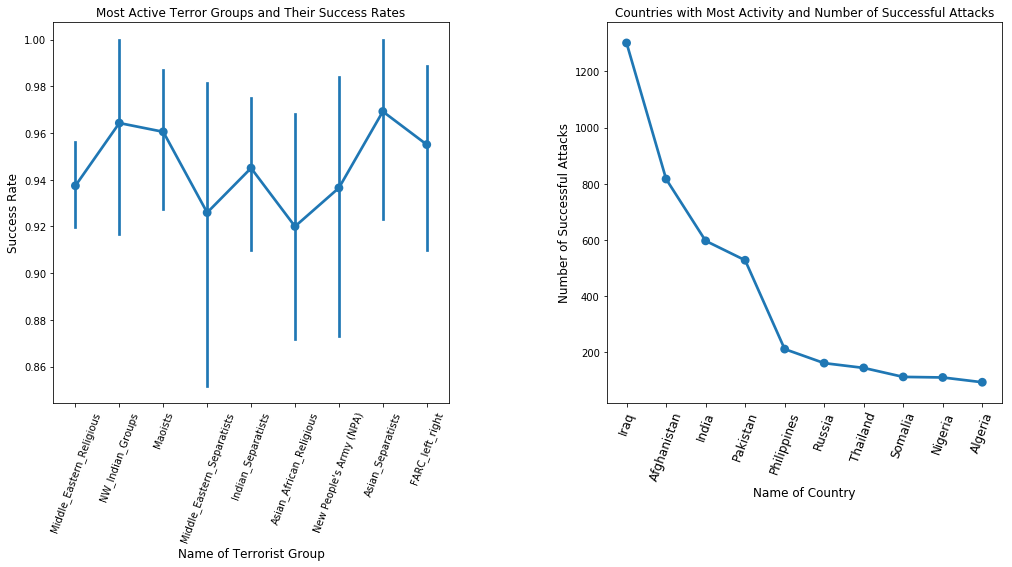

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (17, 7))

plt.subplot(1, 2, 1)
ax1 = sns.pointplot(x = actives_df['group_name'], y = temp_output['success'])
ax1.set_xticklabels(labels = beta_1, rotation = '70', fontdict = {'fontsize':10})
ax1.set_xlabel('Name of Terrorist Group', fontdict = {'fontsize':12})
ax1.set_ylabel('Success Rate', fontdict = {'fontsize':12})
ax1.set_title('Most Active Terror Groups and Their Success Rates')
plt.subplots_adjust(wspace = .4)

plt.subplot(1, 2, 2)
ax2 = sns.pointplot(x = beta_2, y = gamma_2)
ax2.set_xticklabels(labels = beta_2, rotation = '70', fontdict = {'fontsize':12})
ax2.set_xlabel('Name of Country', fontdict = {'fontsize':12})
ax2.set_ylabel('Number of Successful Attacks', fontdict = {'fontsize':12})
ax2.set_title('Countries with Most Activity and Number of Successful Attacks')
plt.subplots_adjust(wspace = .4)

plt.show()

#### E. Highly Targeted Areas:

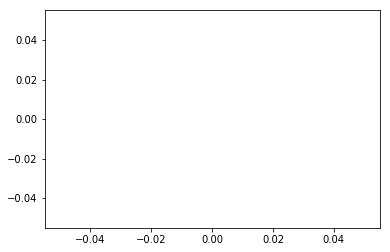

In [36]:
alpha = cyber_train_X['target_1txt'].value_counts()
# beta = cyber_train_X['target_1txt']

sns.scatterplot(x = cyber_train_X['target_1txt'], y = alpha)

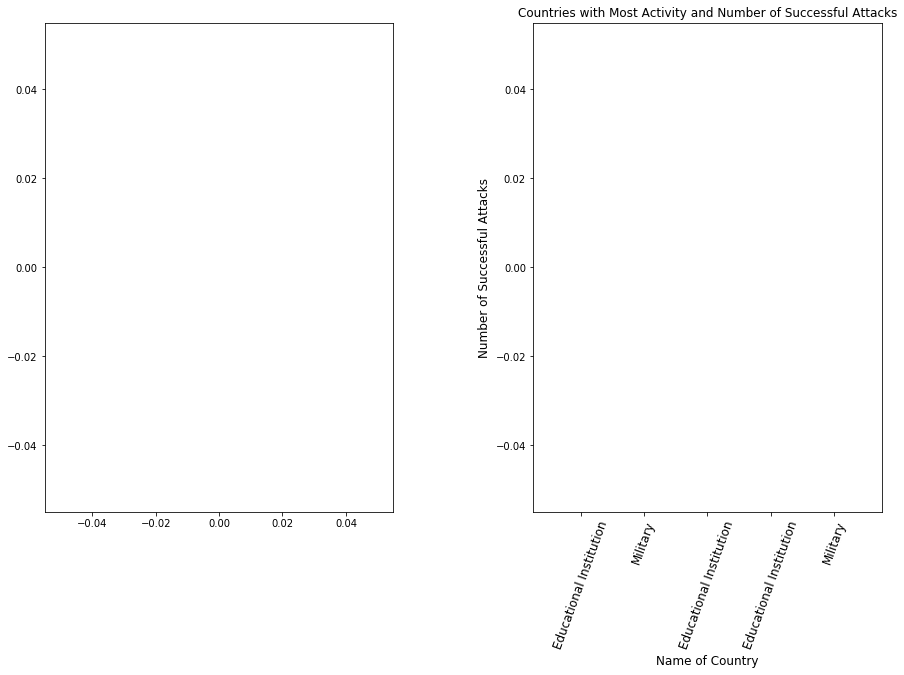

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 9))

plt.subplot(1, 2, 1)
sns.scatterplot(x = cyber_train_X['target_1txt'], y = cyber_train_X['target_1txt'].value_counts())
ax1.set_xticklabels(labels = cyber_data['target_1txt'], rotation = '70', fontdict = {'fontsize':10})
ax1.set_xlabel('Name of Terrorist Group', fontdict = {'fontsize':12})
ax1.set_ylabel('Success Rate', fontdict = {'fontsize':12})
ax1.set_title('Most Active Terror Groups and Their Success Rates')
plt.subplots_adjust(wspace = .4)

plt.subplot(1, 2, 2)
ax2 = sns.scatterplot(x = cyber_train_X['target_1txt'], y = cyber_train_X['target_1txt'].value_counts(),
                     hue = cyber_train_Y['success'], style = cyber_train_X['weapontxt'])
ax2.set_xticklabels(labels = cyber_data['target_1txt'], rotation = '70', fontdict = {'fontsize':12})
ax2.set_xlabel('Name of Country', fontdict = {'fontsize':12})
ax2.set_ylabel('Number of Successful Attacks', fontdict = {'fontsize':12})
ax2.set_title('Countries with Most Activity and Number of Successful Attacks')
plt.subplots_adjust(wspace = .4)

plt.show()

AttributeError: 'int' object has no attribute 'scatter'

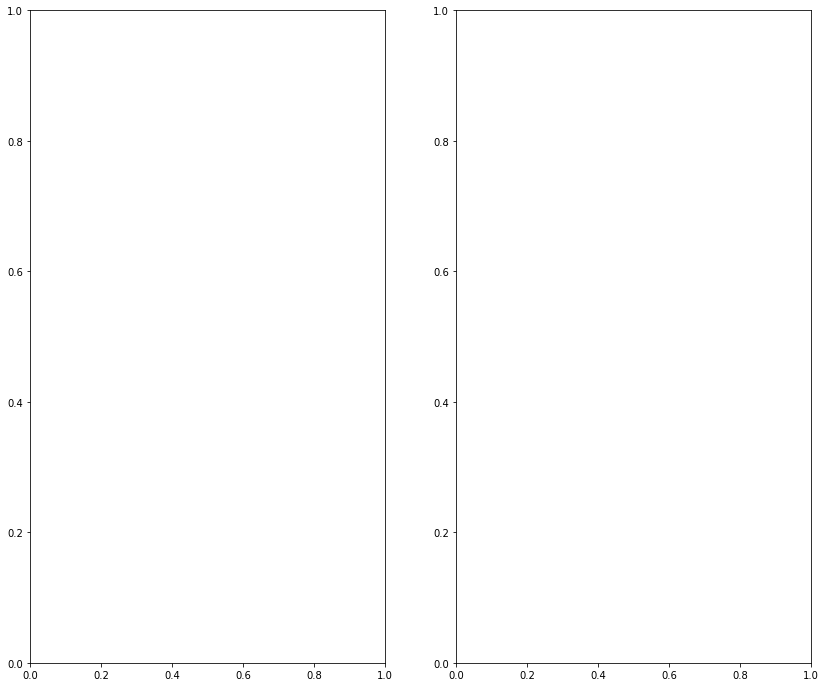

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 12))

sns.scatterplot(x = 'target_1txt', y = cyber_data['target_1txt'].value_counts(), 
                                  hue = 'success', data = cyber_data, ax = 1)

sns.scatterplot(x = 'target_1txt', y = cyber_data['target_1txt'].value_counts(), 
                                  hue = 'success', style = ['weapontxt'], data = cyber_data, ax = 2)
                                  
plt.show()

In [ ]:
cyber_data.keys()

In [ ]:
del actives, actives_df, temp_output, beta, hot_countries, hot_countries_df, phi, temp_output2, mask3
gc.collect()

### 3. Feature Selection:

Getting closer to modeling and using feature selection algorithms to see what will help us best minimize our feature set while maintaining the most amount of variation in our data.

We mainly focused on Select KBest within sklearn and PCA analysis to give us two perspectives on the data (one that we can parse out as humans, namely Select KBest, and one that is mostly computationally described, namely PCA). 

#### A. Select K-Best:

##### Assessing the Overall DataFrame and its Features:

In [ ]:
from sklearn import feature_selection

In [ ]:
# Getting dummies on our training and test sets (slight wrangling involved):
  # First dropping any na's:
cyber_train_X.dropna(axis = 0, inplace = True)
cyber_test_X.dropna(axis = 0, inplace = True)

  # Then grabbing an index to make sure we maintain our train/test split:
train_index = cyber_train_X.index
test_index = cyber_test_X.index

  # Dummy-time (we combined the dataframes here to make sure we didn't get duplicated dummies in both 
    # training and test sets):
dummy_prep = pd.concat([cyber_train_X, cyber_test_X]).drop(['group_name', 'city', 'weapontxt'], axis = 1)
dummy_1 = pd.get_dummies(dummy_prep)

  # Re-filtering our Training/Test Inputs:
cyber_train_dummy_X = dummy_1.loc[train_index]
cyber_test_dummy_X = dummy_1.loc[test_index]

  # Re-filtering our Training/Test Outputs:
cyber_train_dummy_Y = cyber_train_Y.loc[train_index]
cyber_test_dummy_Y = cyber_test_Y.loc[test_index]

In [ ]:
# Making sure we have the same sizes still:
print(cyber_train_dummy_X.shape)
print(cyber_test_dummy_X.shape)

In [ ]:
# Fitting SelectKBest to our Features and output:
  # Here we tried a number of sizes: 20, 30, 500 and 700. We found that 25-30 got us the best results.
KBest_1 = feature_selection.SelectKBest(k = 25) 
cyber_train_KBest1 = KBest_1.fit_transform(cyber_train_dummy_X, cyber_train_dummy_Y)

# Transforming the test-set
cyber_test_KBest1 = KBest_1.transform(cyber_test_dummy_X)

In [ ]:
# Creating a DF with the top 25 features:
feature_mask = KBest_1.get_support(indices = True)
KBest_1_features = pd.DataFrame(cyber_train_dummy_X.columns[feature_mask])

KBest_1_features

Here, we are getting a lot of return from the attack, target, sub-target and a few country features.  The doubt column indicates whether doubt exists regarding the classification of this incident as a terrorist incident, as opposed to some sort of other crime.  High-correlation here would make sense, but for now, we will focus on the columns below as the doubt feature is potentially over-correlated.

##### Assessing Individual Features:

Running SelectKBest on a few features individually to see which of their values is selected as most important.  This will help us consolidate some of those values and make a more specific dataframe. 


###### Group_name:

In [ ]:
# Getting dummies on our training and test sets (slight wrangling involved):
names_train_X = cyber_train_X['group_name']
names_test_X = cyber_test_X['group_name']

names_train_index = cyber_train_X['group_name'].index
names_test_index = cyber_test_X['group_name'].index

names_dummy_prep = pd.concat([names_train_X, names_test_X])
names_dummy_1 = pd.get_dummies(names_dummy_prep)

# Filtering Training/Test Inputs:
names_train_dummy_X = names_dummy_1.loc[names_train_index]
names_test_dummy_X = names_dummy_1.loc[names_test_index]

# Filtering Training Outputs:
names_train_dummy_Y = cyber_train_Y.loc[names_train_index]
names_test_dummy_Y = cyber_test_Y.loc[names_test_index]

In [ ]:
# Fitting model to our features and output.
  # Again, we tried 30, 50 and 150, here. It seemed like 25-30 features gave us the best results.
KBest_names = feature_selection.SelectKBest(k = 25)  
names_train_KBest = KBest_names.fit_transform(names_train_dummy_X, names_train_dummy_Y)

# Transforming our test set.
names_test_KBest = KBest_names.transform(names_test_dummy_X)

In [ ]:
# Summarizing the scores for those top 25 features in a df:

names_mask = KBest_names.get_support(indices = True)
KBest_names_features = pd.DataFrame(names_train_dummy_X.columns[names_mask])

KBest_names_features

It looks like some of our groupings from above made it into the top-25 features, which is reassuring that our efforts above produced a result.  This also gives us a slightly broader view of the terrorist groups that are highly active, as opposed to overly-specific groups that might wash out the activity in other countries.

This also points to another issue for consideration when performing future work on the dataset. When making these groups and filters, one will want to be sure to create groups that consider as much of the globe as possible. Otherwise, one would run the risk of coagulating a few groups together from one area, thereby increasing their significance, and over-powering the significance of other groups.  The groups we created above were an attempt at creating well-represented portions of the globe.  It would benefit, however, from more time and research so as to further tweak these groupings towards a higher accuracy.

###### City:

In [ ]:
# Getting dummies on our training and test sets (slight wrangling involved):
city_train_X = cyber_train_X['city']
city_test_X = cyber_test_X['city']

city_train_index = cyber_train_X['city'].index
city_test_index = cyber_test_X['city'].index

city_dummy_prep = pd.concat([city_train_X, city_test_X])
city_dummy_1 = pd.get_dummies(city_dummy_prep)

# Training/Test Inputs:
city_train_dummy_X = city_dummy_1.loc[city_train_index]
city_test_dummy_X = city_dummy_1.loc[city_test_index]

# Training Output:
city_train_dummy_Y = cyber_train_Y.loc[city_train_index]
city_test_dummy_Y = cyber_test_Y.loc[city_test_index]

In [ ]:
# Fitting model to our features and output.
KBest_city = feature_selection.SelectKBest(k = 25) # Tried 30 and 150. 25-30 was our best range.
city_train_KBest = KBest_city.fit_transform(city_train_dummy_X, city_train_dummy_Y)

# Transforming our test set:
city_test_KBest = KBest_city.transform(city_test_dummy_X)

In [ ]:
# Summarizing the scores for those top 25 features in a df:
pd.set_option('max_rows', 101)
city_mask = KBest_city.get_support(indices = True)
KBest_city_features = pd.DataFrame(city_train_dummy_X.columns[city_mask])
KBest_city_features

###### Weapontxt (weapon_train_dummy/weapon_train_output2):

In [ ]:
# Getting dummies on our training and test sets (slight wrangling involved):
weapon_train_X = cyber_train_X['weapontxt']
weapon_test_X = cyber_test_X['weapontxt']

weapon_train_index = cyber_train_X['weapontxt'].index
weapon_test_index = cyber_test_X['weapontxt'].index

weapon_dummy_prep = pd.concat([weapon_train_X, weapon_test_X])
weapon_dummy_1 = pd.get_dummies(weapon_dummy_prep)

# Training/Test Inputs:
weapon_train_dummy_X = weapon_dummy_1.loc[weapon_train_index]
weapon_test_dummy_X = weapon_dummy_1.loc[weapon_test_index]

# Training Output:
weapon_train_dummy_Y = cyber_train_Y.loc[weapon_train_index]
weapon_test_dummy_Y = cyber_test_Y.loc[weapon_test_index]

In [ ]:
# Fitting the model to our features and training output:

KBest_weapon = feature_selection.SelectKBest(k = 3) # Tried 5, but 3 was best.
weapon_train_KBest = KBest_weapon.fit_transform(weapon_train_dummy_X, weapon_train_dummy_Y)

# Transforming our test set:
weapon_test_KBest = KBest_weapon.transform(weapon_test_dummy_X)

In [ ]:
# Summarizing the scores for those top 3 features in a df:

weapon_mask = KBest_weapon.get_support(indices = True)
KBest_weapon_features = pd.DataFrame(weapon_train_dummy_X.columns[weapon_mask])
KBest_weapon_features 

From here, we can infer that while the data-set we are looking at somehow has consequences for cyber infrastructre or networks (including email and social networks as well as the physical networks), there seems to be a correlation with bombings and incendiary methods as well.  As such, we cannot rule out the possibility that cyber-related attacks are often related to physical or other forms of terrorist attacks (at least in the current analysis we are doing here).

In [ ]:
del dummy_prep
del dummy_1
del names_dummy_prep
del names_dummy_1
del city_dummy_prep
del city_dummy_1
del weapon_dummy_prep
del weapon_dummy_1

gc.collect()

#### B. Principle Component Analysis:
##### Assessing the Overall DataFrame:

In [ ]:
from sklearn.decomposition import PCA

# Using the whole dataset (cyber_train_data):
PCA_1 = PCA(n_components = 25)  # Tried 30 and 500
cyber_train_PCA = PCA_1.fit_transform(cyber_train_dummy_X)  
cyber_test_PCA = PCA_1.transform(cyber_test_dummy_X)

##### Assessing Individual Features

###### Group_name:

In [ ]:
# Now looking at group_name values:
PCA_name = PCA(n_components = 25) # Tried 30 and 150
name_train_PCA = PCA_name.fit_transform(names_train_dummy_X)
name_test_PCA = PCA_name.transform(names_test_dummy_X)

###### City:

In [ ]:
# Then some city stuff:
PCA_cities = PCA(n_components = 25) # Tried 30 and 150
cities_train_PCA = PCA_cities.fit_transform(city_train_dummy_X)
cities_test_PCA = PCA_cities.transform(city_test_dummy_X)

###### Weapontxt:

In [ ]:
# Group_subweapon:
PCA_weapon = PCA(n_components = 3)  # Tried 5
weapon_train_PCA = PCA_weapon.fit_transform(weapon_train_dummy_X)
weapon_test_PCA = PCA_weapon.transform(weapon_test_dummy_X)

#### C. Creating Specified DF with Selected Features:

##### DataFrame from KBest Algorithms:

In [ ]:
# Training:
alpha = pd.DataFrame(cyber_train_KBest1, columns = KBest_1_features[0])
beta = pd.DataFrame(names_train_KBest, columns = KBest_names_features[0])
gamma = pd.DataFrame(city_train_KBest, columns = KBest_city_features[0])
delta = pd.DataFrame(weapon_train_KBest, columns = KBest_weapon_features[0])

KBest_train_X = pd.concat([alpha, beta, gamma, delta], axis = 1)

In [ ]:
# Test:
alpha2 = pd.DataFrame(cyber_test_KBest1, columns = KBest_1_features[0])
beta2 = pd.DataFrame(names_test_KBest, columns = KBest_names_features[0])
gamma2 = pd.DataFrame(city_test_KBest, columns = KBest_city_features[0])
delta2 = pd.DataFrame(weapon_test_KBest, columns = KBest_weapon_features[0])

KBest_test_X = pd.concat([alpha2, beta2, gamma2, delta2], axis = 1)

In [ ]:
del alpha
del beta
del gamma
del delta
del alpha2
del beta2
del gamma2
del delta2
del cyber_train_KBest1
del names_train_KBest
del city_train_KBest
del weapon_train_KBest
del cyber_test_KBest1
del names_test_KBest
del city_test_KBest
del weapon_test_KBest

gc.collect()

##### DataFrame from PCA:

In [ ]:
# Training:
cyber_train_PCA = pd.DataFrame(cyber_train_PCA)
name_train_PCA = pd.DataFrame(name_train_PCA)
cities_train_PCA = pd.DataFrame(cities_train_PCA)
weapon_train_PCA = pd.DataFrame(weapon_train_PCA)

PCA_train_X = pd.DataFrame()
PCA_train_X = pd.concat([cyber_train_PCA, name_train_PCA, cities_train_PCA, weapon_train_PCA], axis = 1)

In [ ]:
# Test:
cyber_test_PCA = pd.DataFrame(cyber_test_PCA)
name_test_PCA = pd.DataFrame(name_test_PCA)
cities_test_PCA = pd.DataFrame(cities_test_PCA)
weapon_test_PCA = pd.DataFrame(weapon_test_PCA)

PCA_test_X = pd.DataFrame()
PCA_test_X = pd.concat([cyber_test_PCA, name_test_PCA, cities_test_PCA, weapon_test_PCA], axis = 1)

In [ ]:
del cyber_train_PCA
del name_train_PCA
del cities_train_PCA
del weapon_train_PCA
del cyber_test_PCA
del name_test_PCA
del cities_test_PCA
del weapon_test_PCA

gc.collect()

### 4. Preliminary Models:

Starting with a simple Logistic Regression since our output feature is binary. Afterwards, we will move on to our Random Forest, Support Vector Classifier and Gradient Booster. We chose these models since they often work well with binary output features. These models will also be discussed below in more detail.

#### Logistic Regression:

##### KBest Features:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import cross_val_score

KBest_logistic = LogisticRegression()

KBest_logistic = KBest_logistic.fit(KBest_train_X, cyber_train_dummy_Y)
KBest_logistic_train_pred_ = KBest_logistic.predict(KBest_train_X)
KBest_logistic_test_pred_ = KBest_logistic.predict(KBest_test_X)

# Evaluation:
  # Confustion Matrices:    
KBest_logistic_confusion_train = confusion_matrix(cyber_train_dummy_Y, KBest_logistic_train_pred_, labels = [0, 1])
KBest_logistic_confusion_test = confusion_matrix(cyber_test_dummy_Y, KBest_logistic_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
KBest_logistic_cv = cross_val_score(KBest_logistic, KBest_train_X, cyber_train_dummy_Y, 
                                    scoring = 'balanced_accuracy', cv = 5)

  # Looking at balanced accuracy/f1 scores:
KBest_logistic_train = balanced_accuracy_score(cyber_train_dummy_Y, KBest_logistic_train_pred_)    
KBest_logistic_test = balanced_accuracy_score(cyber_test_dummy_Y, KBest_logistic_test_pred_)    

In [ ]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(KBest_logistic_cv.mean(),
                                                                     plusminus, KBest_logistic_cv.std()))
print("The cv scores are: {}".format(KBest_logistic_cv))

conf_df = pd.DataFrame(KBest_logistic_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(KBest_logistic_train))

conf_df2 = pd.DataFrame(KBest_logistic_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(KBest_logistic_test))

In [ ]:
del KBest_logistic
del KBest_logistic_train_pred_
del KBest_logistic_test_pred_ 
del KBest_logistic_confusion_train
del KBest_logistic_confusion_test
del KBest_logistic_cv
del KBest_logistic_train
del KBest_logistic_test
gc.collect()

##### PCA Features:

In [ ]:
PCA_logistic = LogisticRegression()

PCA_logistic = PCA_logistic.fit(PCA_train_X, cyber_train_dummy_Y)
PCA_logistic_train_pred_ = PCA_logistic.predict(PCA_train_X)
PCA_logistic_test_pred_ = PCA_logistic.predict(PCA_test_X)

# Evaluation:
  # Confustion Matrices:    
PCA_logistic_confusion_train = confusion_matrix(cyber_train_dummy_Y, PCA_logistic_train_pred_, labels = [0, 1])
PCA_logistic_confusion_test = confusion_matrix(cyber_test_dummy_Y, PCA_logistic_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
PCA_logistic_cv = cross_val_score(PCA_logistic, PCA_train_X, cyber_train_dummy_Y,
                                  scoring = 'balanced_accuracy', cv = 5)

  # Looking at balanced accuracy/f1 scores:
PCA_logistic_train = balanced_accuracy_score(cyber_train_dummy_Y, PCA_logistic_train_pred_)    
PCA_logistic_test = balanced_accuracy_score(cyber_test_dummy_Y, PCA_logistic_test_pred_)    

In [ ]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(PCA_logistic_cv.mean(),
                                                                     plusminus, PCA_logistic_cv.std()))
print("The cv scores are: {}".format(PCA_logistic_cv))

conf_df = pd.DataFrame(PCA_logistic_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(PCA_logistic_train))

conf_df2 = pd.DataFrame(PCA_logistic_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(PCA_logistic_test))

Now, while we do have some decent scores here, especially regarding the true positive predictions, we do have a class imbalance issue we will need to take into consideration (as demonstrated below).  One way of doing that will work on increasing the accuracy of our true negatives and focusing less on our true positives. It will also help to take into consideration our False Negatives and Positives. Lowering these will help strengthen our model and give us more predictive integrity.  In other words, we want to make sure we avoid as many False Negatives (i.e. instances where our model does not predict a terrorist attack, when instead one does, in fact, occur) as possible.  We also want to be sure we are keeping our False Positive count as low as possible since responding to predicted terrorist incidents when there are none will exhaust resources and employees - in turn taking away their energies from realistic threats. 

In order to do so, we have implemented the Balanced Accuracy score, which gives us an average of our False Negatives and Positives.  It allows us to consider another aspect of the model results outside of the training and test-set scores (which only allow us to see on aspect of a model's predictive results).  The Balanced Accuracy is a nice addition to the confusion matrix, which gives us the hard-numbers which are factored into the Balanced Accuracy score.  In assessing the models above along with those below, we will be looking at all of these evaluation methods in order to determine which model is the best and make our reasoning as well-rounded as possible. 

In [ ]:
print(cyber_train_dummy_Y.success.value_counts())
print(cyber_test_dummy_Y.success.value_counts())

In [ ]:
del PCA_logistic
del PCA_logistic_train_pred_
del PCA_logistic_test_pred_ 
del PCA_logistic_confusion_train
del PCA_logistic_confusion_test
del PCA_logistic_cv
del PCA_logistic_train
del PCA_logistic_test
gc.collect()

#### Random Forest:

##### KBest Features:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

KBest_forest = RandomForestClassifier(n_estimators = 30, max_depth = 12)

KBest_forest = KBest_forest.fit(KBest_train_X, cyber_train_dummy_Y)
KBest_forest_train_pred_ = KBest_forest.predict(KBest_train_X)
KBest_forest_test_pred_ = KBest_forest.predict(KBest_test_X)

# Evaluation:
  # Confustion Matrices:    
KBest_forest_confusion_train = confusion_matrix(cyber_train_dummy_Y, KBest_forest_train_pred_, labels = [0, 1])
KBest_forest_confusion_test = confusion_matrix(cyber_test_dummy_Y, KBest_forest_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
KBest_forest_cv = cross_val_score(KBest_forest, KBest_train_X, cyber_train_dummy_Y, 
                                  scoring = 'balanced_accuracy', cv = 5)

  # Looking at balanced accuracy/f1 scores:
KBest_forest_train = balanced_accuracy_score(cyber_train_dummy_Y, KBest_forest_train_pred_)    
KBest_forest_test = balanced_accuracy_score(cyber_test_dummy_Y, KBest_forest_test_pred_)    
    

In [ ]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(KBest_forest_cv.mean(),
                                                                     plusminus, KBest_forest_cv.std()))
print("The cv scores are: {}".format(KBest_forest_cv))

conf_df = pd.DataFrame(KBest_forest_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(KBest_forest_train))

conf_df2 = pd.DataFrame(KBest_forest_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(KBest_forest_test))

print('\n\nFeature Importances:\n')
feat_imp = pd.DataFrame(KBest_forest.feature_importances_.round(2), index = KBest_train_X.columns, 
                        columns = ["Importances"])
display(feat_imp.sort_values('Importances', ascending = False))

In [ ]:
del KBest_forest
del KBest_forest_train_pred_
del KBest_forest_test_pred_ 
del KBest_forest_confusion_train
del KBest_forest_confusion_test
del KBest_forest_cv
del KBest_forest_train
del KBest_forest_test
gc.collect()

##### PCA Features

In [ ]:
PCA_forest = RandomForestClassifier()

PCA_forest = PCA_forest.fit(PCA_train_X, cyber_train_dummy_Y)
PCA_forest_train_pred_ = PCA_forest.predict(PCA_train_X)
PCA_forest_test_pred_ = PCA_forest.predict(PCA_test_X)

# Evaluation:
  # Confusion Matrices:
PCA_forest_confusion_train = confusion_matrix(cyber_train_dummy_Y, PCA_forest_train_pred_, labels = [0, 1])
PCA_forest_confusion_test = confusion_matrix(cyber_test_dummy_Y, PCA_forest_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
PCA_forest_cv = cross_val_score(PCA_forest, PCA_train_X, cyber_train_dummy_Y, 
                                scoring = 'balanced_accuracy', cv = 5)

  # Looking and balanced accuracy/f1 scores:
PCA_forest_train = balanced_accuracy_score(cyber_train_dummy_Y, PCA_forest_train_pred_)    
PCA_forest_test = balanced_accuracy_score(cyber_test_dummy_Y, PCA_forest_test_pred_)    

In [ ]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(PCA_forest_cv.mean(),
                                                                     plusminus, PCA_forest_cv.std()))
print("The cv scores are: {}".format(PCA_forest_cv))

conf_df = pd.DataFrame(PCA_forest_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(PCA_forest_train))

conf_df2 = pd.DataFrame(PCA_forest_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(PCA_forest_test))


Here, we can see quite a bit of over-fitting given that the training score and balanced accuracy scores are nearly perfect, while the test score is about 5 percentage points lower than the training score and over 20 points below the balanced accuracy (a drastic difference compared to what we have seen thus far). The nice aspect about the Random Forest, however, is that it lets us look into the feature importances which were used in creating the model, which we saw in the KBest model above.

In [ ]:
del PCA_forest
del PCA_forest_train_pred_
del PCA_forest_test_pred_ 
del PCA_forest_confusion_train
del PCA_forest_confusion_test
del PCA_forest_cv
del PCA_forest_train
del PCA_forest_test
gc.collect()

#### Support Vector Classifier:

##### KBest Features:

In [ ]:
from sklearn.svm import SVC

KBest_SVC = SVC()

KBest_SVC = KBest_SVC.fit(KBest_train_X, cyber_train_dummy_Y)
KBest_SVC_train_pred_ = KBest_SVC.predict(KBest_train_X)
KBest_SVC_test_pred_ = KBest_SVC.predict(KBest_test_X)

# Evaluation:
  # Confusion matrices:
KBest_SVC_confusion_train = confusion_matrix(cyber_train_dummy_Y, KBest_SVC_train_pred_, labels = [0, 1])
KBest_SVC_confusion_test = confusion_matrix(cyber_test_dummy_Y, KBest_SVC_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
KBest_SVC_cv = cross_val_score(KBest_SVC, KBest_train_X, cyber_train_dummy_Y, 
                               scoring = 'balanced_accuracy', cv = 5)

  # Looking at balanced accuracy/f1 scores:
KBest_SVC_train = balanced_accuracy_score(cyber_train_dummy_Y, KBest_SVC_train_pred_)
KBest_SVC_test = balanced_accuracy_score(cyber_test_dummy_Y, KBest_SVC_test_pred_)    

In [ ]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(KBest_SVC_cv.mean(),
                                                                     plusminus, KBest_SVC_cv.std()))
print("The cv scores are: {}".format(KBest_SVC_cv))

conf_df = pd.DataFrame(KBest_SVC_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(KBest_SVC_train))

conf_df2 = pd.DataFrame(KBest_SVC_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(KBest_SVC_test))

In [ ]:
del KBest_SVC
del KBest_SVC_train_pred_
del KBest_SVC_test_pred_ 
del KBest_SVC_confusion_train
del KBest_SVC_confusion_test
del KBest_SVC_cv
del KBest_SVC_train
del KBest_SVC_test
gc.collect()

##### PCA Features

In [ ]:
PCA_SVC = SVC()

PCA_SVC = PCA_SVC.fit(PCA_train_X, cyber_train_dummy_Y)
PCA_SVC_train_pred_ = PCA_SVC.predict(PCA_train_X)
PCA_SVC_test_pred_ = PCA_SVC.predict(PCA_test_X)

# Evaluation:
  # Confusion Matrices:
PCA_SVC_confusion_train = confusion_matrix(cyber_train_dummy_Y, PCA_SVC_train_pred_, labels = [0, 1])
PCA_SVC_confusion_test = confusion_matrix(cyber_test_dummy_Y, PCA_SVC_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
PCA_SVC_cv = cross_val_score(PCA_SVC, PCA_train_X, cyber_train_dummy_Y, 
                             scoring = 'balanced_accuracy', cv = 5)

  # Looking at the F1/balanced accuracy scores:
PCA_SVC_train = balanced_accuracy_score(cyber_train_dummy_Y, PCA_SVC_train_pred_)
PCA_SVC_test = balanced_accuracy_score(cyber_test_dummy_Y, PCA_SVC_test_pred_)

In [ ]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(PCA_SVC_cv.mean(),
                                                                     plusminus, PCA_SVC_cv.std()))
print("The cv scores are: {}".format(PCA_SVC_cv))

conf_df = pd.DataFrame(PCA_SVC_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(PCA_SVC_train))

conf_df2 = pd.DataFrame(PCA_SVC_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(PCA_SVC_test))

These support vector models are considerably stable in the sense that they are able to achieve similar test scores throughout various rounds, which is good.  The balanced accuracy scores are decent and the amount of error is considerably less than the models above. Let's take a look at one more round of model-type before we make this our official model.

In [ ]:
del PCA_SVC
del PCA_SVC_train_pred_
del PCA_SVC_test_pred_ 
del PCA_SVC_confusion_train
del PCA_SVC_confusion_test
del PCA_SVC_cv
del PCA_SVC_train
del PCA_SVC_test
gc.collect()

#### Gradient Boosting:

##### KBest Features:

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

KBest_GBC = GradientBoostingClassifier()

KBest_GBC = KBest_GBC.fit(KBest_train_X, cyber_train_dummy_Y)
KBest_GBC_train_pred_ = KBest_GBC.predict(KBest_train_X)
KBest_GBC_test_pred_ = KBest_GBC.predict(KBest_test_X)

# Evaluation:
  # Confusion matrices:    
KBest_GBC_confusion_train = confusion_matrix(cyber_train_dummy_Y, KBest_GBC_train_pred_, labels = [0, 1])
KBest_GBC_confusion_test = confusion_matrix(cyber_test_dummy_Y, KBest_GBC_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
KBest_GBC_cv = cross_val_score(KBest_GBC, KBest_train_X, cyber_train_dummy_Y, 
                               scoring = 'balanced_accuracy', cv = 5)


  # Looking at the F1/balanced-accuracy scores:
KBest_GBC_train = balanced_accuracy_score(cyber_train_dummy_Y, KBest_GBC_train_pred_)
KBest_GBC_test = balanced_accuracy_score(cyber_test_dummy_Y, KBest_GBC_test_pred_)

In [ ]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(KBest_GBC_cv.mean(),
                                                                     plusminus, KBest_GBC_cv.std()))
print("The cv scores are: {}".format(KBest_GBC_cv))

conf_df = pd.DataFrame(KBest_GBC_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(KBest_GBC_train))

conf_df2 = pd.DataFrame(KBest_GBC_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(KBest_GBC_test))

print('\n\nFeature Importances:\n')
feat_imp = pd.DataFrame(KBest_GBC.feature_importances_.round(2), index = KBest_train_X.columns, 
                        columns = ["Importances"])
display(feat_imp.sort_values('Importances', ascending = False))

In [ ]:
del KBest_GBC
del KBest_GBC_train_pred_
del KBest_GBC_test_pred_ 
del KBest_GBC_confusion_train
del KBest_GBC_confusion_test
del KBest_GBC_cv
del KBest_GBC_train
del KBest_GBC_test
gc.collect()

##### PCA Features

In [ ]:
PCA_GBC = GradientBoostingClassifier()

PCA_GBC = PCA_GBC.fit(PCA_train_X, cyber_train_dummy_Y)
PCA_GBC_train_pred_ = PCA_GBC.predict(PCA_train_X) 
PCA_GBC_test_pred_ = PCA_GBC.predict(PCA_test_X) 

# Evaluation:

  # Confusion matrices:
PCA_GBC_confusion_train = confusion_matrix(cyber_train_dummy_Y, PCA_GBC_train_pred_, labels = [0, 1])
PCA_GBC_confusion_test = confusion_matrix(cyber_test_dummy_Y, PCA_GBC_test_pred_, labels = [0, 1])

  # Cross_validation and train/test score:
PCA_GBC_cv = cross_val_score(PCA_GBC, PCA_train_X, cyber_train_dummy_Y, 
                             scoring = 'balanced_accuracy', cv = 5)

  # Looking at the F1/balanced accuracy scores:
PCA_GBC_train = balanced_accuracy_score(cyber_train_dummy_Y, PCA_GBC_train_pred_)
PCA_GBC_test = balanced_accuracy_score(cyber_test_dummy_Y, PCA_GBC_test_pred_)

In [ ]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(PCA_GBC_cv.mean(),
                                                                     plusminus, PCA_GBC_cv.std()))
print("The cv scores are: {}".format(PCA_GBC_cv))

conf_df = pd.DataFrame(PCA_GBC_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(PCA_GBC_train))

conf_df2 = pd.DataFrame(PCA_GBC_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(PCA_GBC_test))

In [ ]:
del PCA_GBC
del PCA_GBC_train_pred_
del PCA_GBC_test_pred_ 
del PCA_GBC_confusion_train
del PCA_GBC_confusion_test
del PCA_GBC_cv
del PCA_GBC_train
del PCA_GBC_test
gc.collect()

#### Summary of First Models:

> Based on these preliminary results, we were able to get relatively similar results from nearly all models, but it looks like our Random Forest Classifier did best (with the Support Vector Classifier coming in at a close second). In addition, the Random Forest model did best with the KBest feature-set. We will try and focus on the Random Forest model with our next phase and tune the parameters to see if we can optimize those results.  

> Now onto tuning our model!

In [ ]:

del PCA_weapon
del PCA_name
del PCA_cities
del PCA_1
del KBest_weapon
del KBest_names
del KBest_city
del KBest_1
del city_mask
del feature_mask
del names_mask
del weapon_mask
del feature_selection
del KBest_weapon_features
del conf_df
del conf_df2
del KBest_city_features
del KBest_names_features
del KBest_1_features
del weapon_test_index
del city_test_dummy_Y
del names_test_dummy_Y
del weapon_test_dummy_Y
del weapon_test_dummy_X
del X_test_start_index
del city_test_index
del names_test_index
del weapon_train_index
del city_train_dummy_Y
del names_train_dummy_Y
del weapon_train_dummy_Y
del weapon_train_dummy_X
del city_train_index
del names_train_index
del names_test_dummy_X
del names_train_X
del city_train_X
del weapon_train_X
del names_test_X
del city_test_X
del weapon_test_X
del PosT2
del PosT
del first_responders
del names_train_dummy_X
del city_test_dummy_X
del city_train_dummy_X
gc.collect()

In [ ]:

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes

cleaner = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
cleaner

### 5. Improving our Scores:

#### A. Investigating the Data Itself:



### 6. Tuning our Final Model:

Here, we will try and use a for loop to run through a set of parameters, which we will then use to visualize the parameters which will optimize our model's predictive power.  For the moment, the parameters we will focus on are the 'n_estimators' and 'max_depth.'

#### A. RandomForest with KBest:

In [ ]:
from sklearn

In [ ]:
KBest_Grid = RandomForestClassifier(criterion = 'entropy')

params = [{'n_estimators': np.arange(30, 250, 20), 'max_depth': np.arange(3, 13, 1)}]

In [ ]:
param_dict = {'n_estimators': [15, 20, 25, 30, 35, 40, 50, 65, 80, 100, 130, 175, 200], 
              'max_depth' : [3, 4, 3, 4, 7, 8, 9, ]}

param_df = pd.DataFrame(param_dict)

In [ ]:
np.arange()

results_list = []
plusminus = u"\u00B1"

for row in param_df.itertuples(index = False):

    KBest_RF = RandomForestClassifier(C = row[0])

    KBest_RF = KBest_RF.fit(KBest_train_X, cyber_train_dummy_Y)
    KBest_RF_train_pred_ = KBest_RF.predict(KBest_train_X) 
    KBest_RF_test_pred_ = KBest_RF.predict(KBest_test_X) 

    # Evaluation:

      # Confusion matrices:
    KBest_RF_confusion_train = confusion_matrix(cyber_train_dummy_Y, KBest_RF_train_pred_, labels = [0, 1])
    KBest_RF_confusion_test = confusion_matrix(cyber_test_dummy_Y, KBest_RF_test_pred_, labels = [0, 1])

      # Cross_validation and train/test score:
    KBest_RF_cv = cross_val_score(KBest_RF, PCA_train_X, cyber_train_dummy_Y, cv = 5, 
                                  scoring = 'balanced_accuracy')

      # Looking at the F1/balanced accuracy scores:
    KBest_RF_train = balanced_accuracy_score(cyber_train_dummy_Y, KBest_RF_train_pred_)
    KBest_RF_test = balanced_accuracy_score(cyber_test_dummy_Y, KBest_RF_test_pred_)
    
      # Getting some scores on cross-validation, False Negatives and Positives and Balanced Accuracy:
    print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(KBest_RF_cv.mean(),
                                                                     plusminus, KBest_RF_cv.std()))
    conf_df = pd.DataFrame(KBest_RF_confusion_train)
  
    FP = conf_df.loc[0, 1]
    FN = conf_df.loc[1, 0]
    NegT = conf_df.iloc[0].sum()
    PosT = conf_df.iloc[1].sum()
    
    print("Training set results:")
    print(conf_df)
    print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
    print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
    print('Balanced Accuracy: {:.2%}\n'.format(KBest_RF_train))
    
    conf_df2 = pd.DataFrame(KBest_RF_confusion_test)

    FP2 = conf_df2.loc[0, 1]
    FN2 = conf_df2.loc[1, 0]
    NegT2 = conf_df2.iloc[0].sum()
    PosT2 = conf_df2.iloc[1].sum()
    
    print("Test set results:")
    print(conf_df2)
    print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
    print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
    print('Balanced Accuracy: {:.2%}'.format(KBest_RF_test))
    print('-----------------')
    
    results_list.append([KBest_RF_test, (FP2 + FN2), KBest_RF_cv.std()])

#### B. Gradient Boosting Classifier with KBest:

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

param_dict2 = {'n_estimators': [70, 90, 60, 70, 50, 300, 400],
              'max_depth': [5, 4, 6, 6, 6, 5, 4]}

param_df2 = pd.DataFrame(param_dict2)

In [ ]:
results_list2 = []

for row in param_df2.itertuples(index = False):

    KBest_GBC = GradientBoostingClassifier(n_estimators = row[0],
                                           max_depth = row[1])

    KBest_GBC = KBest_GBC.fit(KBest_train_X2, cyber_train_dummy_Y)
    KBest_GBC_train_pred_ = KBest_GBC.predict(KBest_train_X2) 
    KBest_GBC_test_pred_ = KBest_GBC.predict(KBest_test_X2) 

    # Evaluation:

      # Confusion matrices:
    KBest_GBC_confusion_train = confusion_matrix(cyber_train_dummy_Y, KBest_GBC_train_pred_, labels = [0, 1])
    KBest_GBC_confusion_test = confusion_matrix(cyber_test_dummy_Y, KBest_GBC_test_pred_, labels = [0, 1])

      # Cross_validation and train/test score:
    KBest_GBC_cv = cross_val_score(KBest_GBC, KBest_train_X2, cyber_train_dummy_Y, cv = 5, scoring = 'f1')
    KBest_GBC_train_score = KBest_GBC.score(KBest_train_X2, cyber_train_dummy_Y)
    KBest_GBC_test_score = KBest_GBC.score(KBest_test_X2, cyber_test_dummy_Y)

      # Looking at the F1/balanced accuracy scores:
    KBest_GBC_train = balanced_accuracy_score(cyber_train_dummy_Y, KBest_GBC_train_pred_)
    KBest_GBC_test = balanced_accuracy_score(cyber_test_dummy_Y, KBest_GBC_test_pred_)
    
      # Getting some scores on cross-validation, False Negatives and Positives and Balanced Accuracy:
    print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(KBest_GBC_cv.mean(),
                                                                     plusminus, KBest_GBC_cv.std()))
    conf_df = pd.DataFrame(KBest_GBC_confusion_train)
  
    FP = conf_df.loc[0, 1]
    FN = conf_df.loc[1, 0]
    NegT = conf_df.iloc[0].sum()
    PosT = conf_df.iloc[1].sum()
    
    print("Training set results:")
    print(conf_df)
    print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
    print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
    print('Balanced Accuracy: {:.2%}\n'.format(KBest_GBC_train))
    
    conf_df2 = pd.DataFrame(KBest_GBC_confusion_test)

    FP2 = conf_df2.loc[0, 1]
    FN2 = conf_df2.loc[1, 0]
    NegT2 = conf_df2.iloc[0].sum()
    PosT2 = conf_df2.iloc[1].sum()
    
    print("Test set results:")
    print(conf_df2)
    print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
    print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
    print('Balanced Accuracy: {:.2%}'.format(KBest_GBC_test))
    print('-----------------')
    
    results_list2.append([KBest_GBC_test, (FP2 + FN2), KBest_GBC_cv.std()])

Thus, after running a few models, it looks like our Gradient Booster model came through in the end with the best results.  The key to tweaking this model a bit more was limiting the max-depth for each tree.  This allowed the model to limit the depth to 11 so as to keep the model relatively efficient and avoid over-fitting (allowing our model some more flexibility with newer, incoming data. 

Even though we tried a number of iterations on the SVC model, we were unable to improve our scores considerably enough from earlier. They were, in fact, worse than our first iterations.  The fact that this Gradient Booster was able to get our False Negatives to under a handful, is noteworthy enough to serve as our selected model for a real-life scenario.

### 6. Final Analysis, Considerations and Avenues for Further Research:

#### Potential Weaknesses:

While we were able to get some decent scores, there are a few things to not regarding this model and its dataset.  First of all, the filters would greatly benefit from further research and detailed attention.  The above filters are merely a start and represent a base amount of research.  It could certainly serve as a starting point for someone with expertise in the field.

In addition, the filters we applied could be susceptible to a certain amount of bias: the filter itself will not be able to catch all instances of cyber-related terrorism conclusively; more likely than not it will miss one certain aspect or another. Increasing the number of eyes on the model and data will help with this.



#### Further research:

Given the richness of the variables within this dataset, there are plenty of avenues for further research.  One could use Regex to search the summary and motive columns for further detail and insight into the nature of these cyber-related tasks.  The filter above is relatively broad and potentially encapsulates instances that many might not consider related to 'cyber' events.  It would be interesting to create a more intricate regex filter which could give us a more detailed understanding of the 'cyber' aspect of these events: How specifically are they related and in what manners? What geographical locations tend to be hotbeds for such activity.  What targets are specified and why?  The 'motive' feature, in particular, could have extensive benefits with prediction, depending on the vocabulary used by those conducting the study and entering the data. 


#### Explanatory v. Predictive Power:

With the current analysis, our goal lies mainly in the predictive power of our model - in other words, its ability to fit with the current data and produce an output with completely new data - preferably an output with as little variation in this new accuracy score as possible. We are trying to look at the trends in our current data and use it to identify the classifications and probabilities in which new or future observations will fall.  An explanatory model, with regards to a dataset describing Terrorism, might have interest to a scholar or an academic institution in the sense that it reveals behaviors and patterns of observations that have already occurred, but it has no bearing on future observations. It would offer no suggestions on what these patterns might say regarding incoming data (and in this case, future terror attacks). 

The caveat, however, is making sure that our model adapts well to new input (or test) data so that the variation between training and test results can be as minimal as possible (i.e. so the difference between the model's prediction and reality is minimal).  Predictive analysis, especially in a terror-related context, involves considerably more risk than an explanatory model, and should be handled with an intense attention to detail and accuracy.





General References:

Referenced the following sites for honing my knowledge of the models, python, etc:

1. https://www.analyticsvidhya.com/blog/2017/06/a-comprehensive-guide-for-linear-ridge-and-lasso-regression/
2. https://machinelearningmastery.com/feature-selection-machine-learning-python/
3. https://medium.com/@pushkarmandot/what-is-the-significance-of-c-value-in-support-vector-machine-28224e852c5a
4. A big shout out to Mike Swirsky for pointing out this link to me (submitted by the user 'Abdou' on Stack Overflow: https://stackoverflow.com/questions/40993626/list-memory-usage-in-ipython-and-jupyter)